In [1]:
from typing import List, Tuple, Type

import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/tmp/ipykernel_197957/2873611465.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_excel('./data/ChemRev_Hydration_Data.xlsx', sheet_name='HydrationData',usecols = 'A:R')   #importing experimental data

/home/danielschweigert/PyCharmProjects/PFSA_Paper/venv/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/danielschweigert/PyCharmProjects/PFSA_Paper/venv/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [3]:
df.head()

,Study,Year,Membrane,EW,Cast,Cast_id,Thickness,PT,Drying_Temp,Pret_Time,Temperature,LV,LV_id,RH_r,RH,lambda,ChemPotential,Equilibrium_hr
0,Alberti,2008,N117,1100,Ext,1,175.0,1,120,15.0,20.0,L,1.0,100.1,100.1,12.4,11220.638568,1.0
1,Alberti,2008,N117,1100,Ext,1,175.0,1,120,15.0,40.0,L,1.0,100.1,100.1,13.2,11986.552464,1.0
2,Alberti,2008,N117,1100,Ext,1,175.0,1,120,15.0,60.0,L,1.0,100.1,100.1,14.0,12752.466359,1.0
3,Alberti,2008,N117,1100,Ext,1,175.0,1,120,15.0,70.0,L,1.0,100.1,100.1,12.7,13135.423307,1.0
4,Alberti,2008,N117,1100,Ext,1,175.0,1,120,15.0,80.0,L,1.0,100.1,100.1,15.4,13518.380255,1.0


### Filter down to relevant data

In [4]:
# description: why filtered out: ...

not_include = ['Cast','LV','RH_r','Pret_Time']
df = df.query('Study != "Alberti" and EW == 1100')
df = df.query('LV_id in (0, 1)')
df['LV_id'] = df['LV_id'].astype(int)
df = df.drop(not_include, axis=1)
df = df[df['Thickness'].notnull()]

In [5]:
# subset 1
# description: remove equilibrium_hr column, divide in liquid and vapor
df_1_columns = df.columns.values.tolist()
df_1_columns.remove('Equilibrium_hr')
df_1 = df[df_1_columns]
print('dataset 1: ', df_1.shape)
df_1_l = df_1[df_1['LV_id']==1]
df_1_l['RH'] = df_1_l['RH'].replace(100.1,100)
df_1_v = df_1[df_1['LV_id']==0]
print('dataset 1_l: ', df_1_l.shape)
print('dataset 1_v: ', df_1_v.shape)

dataset 1:  (613, 13)
dataset 1_l:  (144, 13)
dataset 1_v:  (469, 13)


/tmp/ipykernel_197957/3881678523.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1_l['RH'] = df_1_l['RH'].replace(100.1,100)


In [6]:
# subset 2
# description: non-null Equilibrium_hr data, divide in liquid and vapor
df_2 = df[df['Equilibrium_hr'].notnull()]
print('dataset 2: ', df_2.shape)
df_2_l = df_2[df_2['LV_id']==1]
df_2_v = df_2[df_2['LV_id']==0]
print('dataset 2_l: ', df_2_l.shape)
print('dataset 2_v: ', df_2_v.shape)

dataset 2:  (454, 14)
dataset 2_l:  (117, 14)
dataset 2_v:  (337, 14)


### Question 1:
#### Can we fit a model on material properties and processing conditions to predict performance metric delta lambda?

In [7]:
material_properties = ['Thickness']
processing_conditions_1 = ['PT', 'Cast_id', 'Drying_Temp']
processing_conditions_2 = ['PT', 'Cast_id', 'Drying_Temp', 'Equilibrium_hr']
operating_conditions = ['Temperature']
predictors_1 = material_properties + processing_conditions_1 + operating_conditions
predictors_2 = material_properties + processing_conditions_2 + operating_conditions

In [8]:
def compute_performance_metric_delta_lambda(df: pd.DataFrame) -> pd.DataFrame:
    """
    Input:
    DataFrame with columns
        ...predictors..., LV_id, RH, lambda

    Output:
        DataFrame with columns
        ...predictors..., delta_lambda
    """
    df = df[df['RH'] >= 95.0]
    df['delta_lambda'] = df['lambda_lv_1'] - df['lambda_lv_0']
    df['delta_lambda'] = df['delta_lambda'].apply(lambda x : 0 if x < 0 else x)
    df.drop('RH', axis=1)
    return df


In [9]:
def unstack_liquid_vapor_datasets(df: pd.DataFrame, fixed_columns: List[str]) -> pd.DataFrame:
    """
    Input DataFrame:
        ...fixed_columns..., LV_id, lambda

    Output DataFrame:
        ...fixed_columns..., lambda_lv_0, lambda_lv_1

    example for fixed_columns: [EW, Thickness, PT, Cast_id, Drying_Temp, Equilibrium_hr, Temperature, RH]
    """
    agg_columns = fixed_columns + ['LV_id']
    df_agg = df[agg_columns + ['lambda']].groupby(agg_columns).mean()
    df_agg = df_agg.drop_duplicates().reset_index()
    df_wide = df_agg.set_index(fixed_columns + ['LV_id']).unstack('LV_id')
    df_wide.columns = [f'{col[0]}_lv_{col[1]}' for col in df_wide.columns]
    df_wide = df_wide.reset_index()
    return df_wide


def test_unstack_liquid_vapor_datasets():

    df = pd.DataFrame(
        data={
            'A': [1.4, 2, 3, 4, 4, 5, 5],
            'B': [6, 7, 8.2, 4, 4, 5, 5],
            'LV_id': [0, 1, 0, 1, 0, 1, 1],
            'RH': [50, 100, 90, 100, 100, 99, 99],
            'lambda': [5, 15, 25, 35, 45, 40, 41]
        }
    )

    df_result = unstack_liquid_vapor_datasets(df=df, fixed_columns=['A', 'B', 'RH'])

    print(df)

    print('----')
    print(df_result)


test_unstack_liquid_vapor_datasets()



     A    B  LV_id   RH  lambda
0  1.4  6.0      0   50       5
1  2.0  7.0      1  100      15
2  3.0  8.2      0   90      25
3  4.0  4.0      1  100      35
4  4.0  4.0      0  100      45
5  5.0  5.0      1   99      40
6  5.0  5.0      1   99      41
----
     A    B   RH  lambda_lv_0  lambda_lv_1
0  1.4  6.0   50          5.0          NaN
1  2.0  7.0  100          NaN         15.0
2  3.0  8.2   90         25.0          NaN
3  4.0  4.0  100         45.0         35.0
4  5.0  5.0   99          NaN         40.5


In [10]:
def knn_impute(df: pd.DataFrame, exclude_columns: List, **params) -> pd.DataFrame:
    """
    Perform KNN imputation while excluding specified columns.
    """
    
    qualifying_parameters = ['n_neighbors', 'weights']
    knn_params = {k: params[k] for k in qualifying_parameters if k in params}
    
    knn_imputer = KNNImputer(**knn_params)
    df_copy = df.copy()
    # fit_columns = [_column for _column in df_copy.columns.values if _column not in exclude_columns]
    df_copy = df_copy.drop(exclude_columns, axis=1)
    
    df_copy = pd.DataFrame(knn_imputer.fit_transform(df_copy), columns=df_copy.columns)
    for _column in exclude_columns:
        df_copy[_column] = df[_column]
    
    return df_copy

In [11]:
def fit_regressor_model(df: pd.DataFrame, regressor_class: Type[BaseEstimator], y_column: str = 'delta_lambda') -> float:

    y = df[y_column].values
    x_columns = [_x for _x in df.columns.values if _x != y_column]
    x = df[x_columns].values
    rg = regressor_class()
    kf = KFold(n_splits=3, shuffle=True, random_state=1)
    scores = []
    for _, (train_index, test_index) in enumerate(kf.split(x)):
        x_train = x[train_index]
        y_train = y[train_index]
        x_test = x[test_index]
        y_test = y[test_index]
        rg.fit(x_train, y_train)
        scores.append(rg.score(x_test, y_test))
    return np.mean(scores)

In [28]:
def evaluate_regressor_model(df: pd.DataFrame, regressor_class: Type[BaseEstimator], y_column: str = 'delta_lambda'):
    
    y = df[y_column].values
    x_columns = [_x for _x in df.columns.values if _x != y_column]
    x = df[x_columns].values
    rg = regressor_class()
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=2)
    rg.fit(x_train, y_train)
    y_hat = rg.predict(x_test)
    score = rg.score(x_test, y_test)
    
    plt.scatter(y_test, y_hat)
    plt.title(f"Predicted vs. actual : {y_column} -- score: {score}")

    

In [13]:
df_1_unstacked = unstack_liquid_vapor_datasets(df=df_1, fixed_columns=predictors_1 + ['RH'])
df_1_unstacked

,Thickness,PT,Cast_id,Drying_Temp,Temperature,RH,lambda_lv_0,lambda_lv_1
0,16.0,0,0,150,25.0,1.0,0.220921,NaN
1,16.0,0,0,150,25.0,10.0,1.530159,NaN
2,16.0,0,0,150,25.0,20.0,2.216342,NaN
3,16.0,0,0,150,25.0,30.0,2.794304,NaN
4,16.0,0,0,150,25.0,40.0,3.325459,NaN
...,...,...,...,...,...,...,...,...
424,250.0,1,1,25,75.0,50.0,5.522300,NaN
425,250.0,1,1,25,75.0,60.0,6.174350,NaN
426,250.0,1,1,25,75.0,70.0,7.068250,NaN
427,250.0,1,1,25,75.0,80.0,8.217000,NaN


In [14]:
df_1_imputed = knn_impute(df=df_1_unstacked, exclude_columns=['lambda_lv_0'])
df_1_imputed = knn_impute(df=df_1_imputed, exclude_columns=['lambda_lv_1']) 
df_1_imputed

,Thickness,PT,Cast_id,Drying_Temp,Temperature,RH,lambda_lv_0,lambda_lv_1
0,16.0,0.0,0.0,150.0,25.0,1.0,0.220921,18.245196
1,16.0,0.0,0.0,150.0,25.0,10.0,1.530159,18.245196
2,16.0,0.0,0.0,150.0,25.0,20.0,2.216342,18.245196
3,16.0,0.0,0.0,150.0,25.0,30.0,2.794304,18.245196
4,16.0,0.0,0.0,150.0,25.0,40.0,3.325459,18.245196
...,...,...,...,...,...,...,...,...
424,250.0,1.0,1.0,25.0,75.0,50.0,5.522300,20.474000
425,250.0,1.0,1.0,25.0,75.0,60.0,6.174350,20.474000
426,250.0,1.0,1.0,25.0,75.0,70.0,7.068250,20.474000
427,250.0,1.0,1.0,25.0,75.0,80.0,8.217000,20.474000


In [15]:
df_1_trainable = compute_performance_metric_delta_lambda(df_1_imputed)

/tmp/ipykernel_197957/2203347747.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_lambda'] = df['lambda_lv_1'] - df['lambda_lv_0']
/tmp/ipykernel_197957/2203347747.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_lambda'] = df['delta_lambda'].apply(lambda x : 0 if x < 0 else x)


In [16]:
score = fit_regressor_model(df=df_1_trainable, regressor_class=RandomForestRegressor, y_column='delta_lambda')
score

0.9298246361194895

In [17]:
def screen_pipeline(df: pd.DataFrame, n_neighbor_pool: List[int]):
    
    fixed_columns = [_c for _c in ['Thickness', 'PT', 'Cast_id', 'Drying_Temp', 'Equilibrium_hr', 'RH', 'Temperature'] if _c in df.columns.values.tolist()]
    
    df_1_unstacked = unstack_liquid_vapor_datasets(df=df, fixed_columns=fixed_columns)
    
    n_neighbors = []
    scores = []
    
    for n_neighbor in n_neighbor_pool:
        df_1_imputed = knn_impute(df=df_1_unstacked, exclude_columns=['lambda_lv_0'], n_neighbor=n_neighbor)
        df_1_imputed = knn_impute(df=df_1_imputed, exclude_columns=['lambda_lv_1'], n_neighbor=n_neighbor)
        df_1_trainable = compute_performance_metric_delta_lambda(df_1_imputed)
        score = fit_regressor_model(df=df_1_trainable, regressor_class=RandomForestRegressor, y_column='delta_lambda')
        n_neighbors.append(n_neighbor)
        scores.append(score)
        
    return n_neighbors, scores

In [18]:
def evaluate_pipeline(df: pd.DataFrame, n_neighbor: int):
    
    fixed_columns = [_c for _c in ['Thickness', 'PT', 'Cast_id', 'Drying_Temp', 'Equilibrium_hr', 'RH', 'Temperature'] if _c in df.columns.values.tolist()]
    
    df_1_unstacked = unstack_liquid_vapor_datasets(df=df, fixed_columns=fixed_columns)
    
    df_1_imputed = knn_impute(df=df_1_unstacked, exclude_columns=['lambda_lv_0'], n_neighbor=n_neighbor)
    df_1_imputed = knn_impute(df=df_1_imputed, exclude_columns=['lambda_lv_1'], n_neighbor=n_neighbor)
    df_1_trainable = compute_performance_metric_delta_lambda(df_1_imputed)
    score = evaluate_regressor_model(df=df_1_trainable, regressor_class=RandomForestRegressor, y_column='delta_lambda')


In [19]:
neighbors, scores = screen_pipeline(df=df_1, n_neighbor_pool=list(range(3, 16)))

/tmp/ipykernel_197957/2203347747.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_lambda'] = df['lambda_lv_1'] - df['lambda_lv_0']
/tmp/ipykernel_197957/2203347747.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_lambda'] = df['delta_lambda'].apply(lambda x : 0 if x < 0 else x)
/tmp/ipykernel_197957/2203347747.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

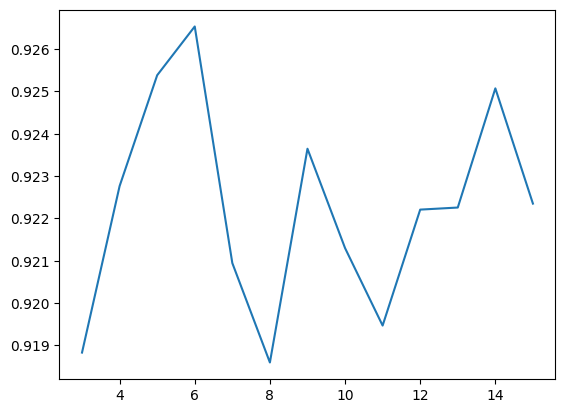

In [20]:
plt.plot(neighbors, scores)

In [21]:
neighbors, scores = screen_pipeline(df=df_2, n_neighbor_pool=list(range(3, 16)))

/tmp/ipykernel_197957/2203347747.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_lambda'] = df['lambda_lv_1'] - df['lambda_lv_0']
/tmp/ipykernel_197957/2203347747.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_lambda'] = df['delta_lambda'].apply(lambda x : 0 if x < 0 else x)
/tmp/ipykernel_197957/2203347747.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

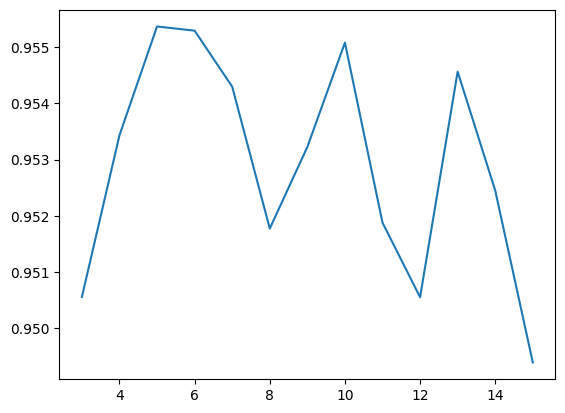

In [22]:
plt.plot(neighbors, scores)

/tmp/ipykernel_197957/2203347747.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_lambda'] = df['lambda_lv_1'] - df['lambda_lv_0']
/tmp/ipykernel_197957/2203347747.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_lambda'] = df['delta_lambda'].apply(lambda x : 0 if x < 0 else x)


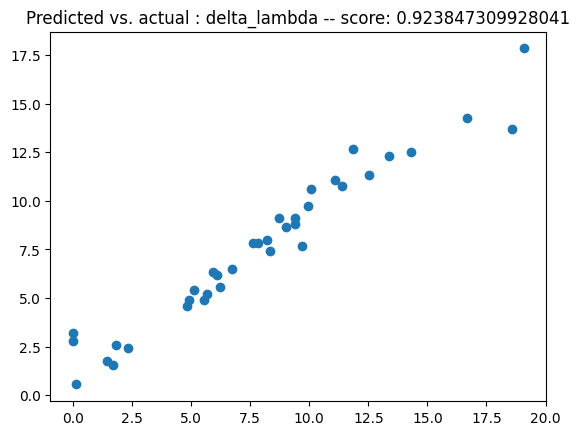

In [29]:
evaluate_pipeline(df=df_1, n_neighbor=6)

/tmp/ipykernel_197957/2203347747.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_lambda'] = df['lambda_lv_1'] - df['lambda_lv_0']
/tmp/ipykernel_197957/2203347747.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_lambda'] = df['delta_lambda'].apply(lambda x : 0 if x < 0 else x)


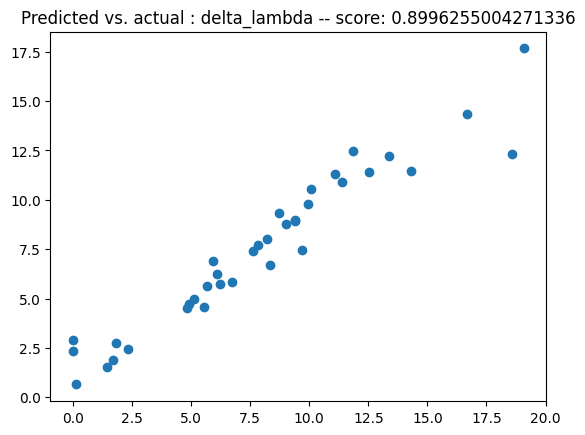

In [30]:
evaluate_pipeline(df=df_1, n_neighbor=5)